# Delta Index and Basin Performance Degradation Correlation 

Notebook X/X

This notebook was written by Logan Qualls. Data for this work is sourced from the National Center for Atmospheric Research's Catchment Attributes and Meterology for Large-Sample Studies (CAMELS) dataset, and this notebook is designed to work specifically with Frederik Kratzert's NeuralHydrology (NH; https://github.com/neuralhydrology/neuralhydrology) and Grey Nearing's SACSMA-SNOW17 (SAC-SMA; https://github.com/Upstream-Tech/SACSMA-SNOW17). NH provides a flexible framework with a variety of tools specifically designed for straightforward application of Long Short-Term Memory networks to hydrological modeling. The SACSMA-SNOW17 model provides a Python interface for the SAC-SMA model.

Here we explore the correlation between the distance between the highest climate index value and the lowest climate index value with how robust the model is in a given basin, i.e. a basin's NSE score in the extreme model minus the basins's NSE score in the random model. Robustness, here, is a measure of resistance to loss of predictive ability.

Essentially, we are trying to see if model performance suffers more in basins experiencing higher variations of a climate index.

### Import Libraries

In [1]:
#Import Python libraries
import os
import sys
import copy
import random
import numpy as np
import pandas as pd
import pickle as pkl
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

#Import NeuralHydrology functions
from functions import config
from functions.utils import load_basin_file

### Define Parameters

In [2]:
#########################################################################################

model = 'nh'

#Climate index input type: 'static' or 'dynamic'
inputs = 'static'

#Experiment type: train/test on 'extreme' or 'random' years
exp_types = ['random','extreme']

#Range of years train/test sets sourced from: 'all' or 'nwm'
years = 'all'

#########################################################################################

Here we need to explicitly define which dynamic input file we are going to reference to calculate the difference between extreme high and extreme low of a defined climate index value.

In [3]:
#########################################################################################

#Forcing source: CAMELS forcing data source? (daymet', 'nldas'(_extended'), 'maurer'(_extended'))
forcing = 'daymet'

#If exp_type == 'extreme': Which indexes do we want to create extreme train/test sets for
climate_index = 'aridity'

#Specify number of basins in name of desired dynamic climate indices file
basin_list_num = 531

#Specify rolling mean window length, also found in name of desired dynamic climate indices file
window = 365

#########################################################################################

##### Paths

In [26]:
#########################################################################################

#Path to working directory (where this notebook is)
working_dir = Path(os.getcwd())

#Path to "configs" directory (../config_complementaries)
config_comp_dir = working_dir / 'config_complementaries'

#Path to folder to save train/test sets to
dates_dir = config_comp_dir / 'train_test_sets'

env_saves_dir = working_dir / 'notebook_env_saves'

#Path to camels basin_dataset_public_v1p2 dir (to be included in config)
camels_dir = working_dir / 'camels' / 'basin_dataset_public_v1p2'

#Path to NeuralHydrology codebase ('../neuralhydrology/neuralhydrology')
nh_dir = working_dir / 'nh' / 'neuralhydrology' / 'neuralhydrology'

#Path to CAMELS attributes, version 2 file
camels_attributes_dir  = working_dir / 'camels' / 'camels_attributes_v2.0/camels_attributes_v2.0.csv'

#Filepath and name to (load or save a) dynamic climate indexes pickle file
climate_indices_file = config_comp_dir / f'dynamic_climate_indices/dyn_clim_indices_{forcing}_{basin_list_num}basins_{window}.p'

#########################################################################################

In [27]:
# #########################################################################################

# #Path to working_dir (current directory)
# working_dir = Path(os.getcwd())

# #Path to config directory (.../configs)
# config_dir = working_dir / 'nh_lstm' / 'configs'

# #Path to climate indices file (.../additional_features/{climate_file})
# climate_indices_file = config_dir / 'additional_features/dyn_climate_indices_daymet_531basins_365lookback.p'

# #########################################################################################

# #If you use this repository's directory structure, you not need to edit the paths below, but just in case...

# #Path to NH codebase (../neuralhydrology/neuralhydrology)
# nh_dir = working_dir / 'neuralhydrology' / 'neuralhydrology'

# #Path to main CAMELS directory (../camels)
# camels_dir = working_dir / 'camels'

# #Path to CAMELS forcing directory (../basin_dataset_public_v1p2)
# camels_forcing_dir = camels_dir / 'basin_dataset_public_v1p2'

# #Path to extreme dates directory (../train_test_splits)
# dates_dir = working_dir / 'train_test_splits'



# # Path to notebook_env_saves
# env_saves_dir = working_dir / 'notebook_env_saves'

# #########################################################################################

In [ ]:
#maybe first load in experiments??? to get climate index we want? we definitely need basin metrics

### Load Source Data

In [5]:
metrics_dict = {}

for exp_type in exp_types:
    
    if model == 'sacsma':

        file = f'basin_metrics_{model}_{exp_type}_{forcing}_{years}'
        name = f'{model}_{exp_type}_{forcing}_{years}'

    if model == 'nh':

        file = f'basin_metrics_{model}_{inputs}_{exp_type}_{forcing}_{years}.pkl'
        name = f'{model}_{inputs}_{exp_type}_{forcing}_{years}'

    path = env_saves_dir / file

    if os.path.exists(path):

        #Open path...
        with open(path,'rb') as f:

            #...and load
            metrics_dict[name] = pkl.load(f)

In [6]:
#Get model, experiment, metric, and basin information from metrics_dict
#Models
model_names = list(metrics_dict.keys())

rand_model = model_names[0]
ext_model = model_names[1]

#Experiments
rand_exps = list(metrics_dict[rand_model].keys())
ext_exps = [x for x in metrics_dict[ext_model].keys() if 'aridity' in x]
ext_exps = [x for x in ext_exps if climate_index in x]
experiments = rand_exps + ext_exps
#Metrics
metrics = list(metrics_dict[ext_model][ext_exps[0]].keys())
#Basins
basins = list(metrics_dict[ext_model][ext_exps[0]][metrics[0]].index)
basins_int = [int(x) for x in basins]

In [7]:
#Create a metrics_dict indexed by the integer version of the basin id
#For every model...
for model in model_names:
    
    exps = list(metrics_dict[model].keys())
    
    experiments = [x for x in experiments if climate_index in experiments]
    
    #For every experiment...
    for exp in exps:
            
        #Create an index of basin ids as integers
        int_index = [int(x) for x in list(metrics_dict[model][exp].index)]
            
        #Reindex camels ids as integers, not strings
        metrics_dict[model][exp].index = int_index

In [9]:
#Load pickled dynamic climate indices file
with open(climate_indices_file, 'rb') as f:
    climate_indices_dict = pkl.load(f)

In [10]:
# basins = list(climate_indices_dict.keys())

climate_index_dyn = [x for x in climate_indices_dict[basins[0]].keys() if climate_index in x][0]

#If we are creating experiments for only the NWM years...
if years == 'nwm': 

    #For every basin...
    for basin in basins:

        #Trim the datetime index to only include data within the NWM range
        climate_indices_dict[basin] = climate_indices_dict[basin].loc[pd.date_range('1995-10-01','2014-12-30',
                                                                                    freq='D')]

#Check beginning time step
print(f"{forcing} climate indices beginning at",climate_indices_dict[basins[0]].index[0])

# assert len(basins) == len(climate_indices_dict.keys())   


daymet climate indices beginning at 1980-01-01 00:00:00


### Calculate Delta Climate Index

In [11]:
#high, low, ave / could probably do all three at a time for fun but whwateversfas
method = 'high'

In [12]:
delta_clim_index = pd.Series(float,index=basins_int)

for basin in basins:
        
    ci_srt = climate_indices_dict[basin][climate_index_dyn]
        
    dates = ci_srt.index

    end_dates = ci_srt.loc[(dates.month == 9) & (dates.day == 30)].index

    #Exclude first two years to ensure there is no incomplete data years
    end_dates = end_dates[2:]

    #Create a list of hydro years, sorted temporally
    xs = ci_srt[end_dates].sort_values()

    if method == 'high':

        #Most extreme
        x = float(np.max(xs))
        y = float(np.min(xs))
        delta_clim_index[int(basin)] = (x-y)# / xs.std()

    if method == 'low':

        #Lowest extreme of 5
        x = float(np.min(xs[-5:]))
        y = float(np.max(xs[:5]))
        delta_clim_index[int(basin)] = (x-y)# / xs.std()

    if method == 'ave':

        #Average of 5 extremes
        x = float(np.mean(xs.values[-5:]))
        y = float(np.mean(xs.values[:5]))
        delta_clim_index[int(basin)] = (x-y)# / xs.std()


In [13]:
rand_list = []

for exp in rand_exps:
    rand_list.append(metrics_dict[rand_model][exp]['nse'])

mean_rand = np.mean(pd.concat(rand_list,axis=1),axis=1)

In [14]:
nse_df = pd.DataFrame(index=basins_int)

for exp in ext_exps:
    
    if len(basins) == len(metrics_dict[ext_model][exp]['nse'].index):
    
        nse_df[f'{exp}_nse'] = metrics_dict[ext_model][exp]['nse']

In [15]:
delta_nse_df = pd.DataFrame(index=basins_int)

for exp in ext_exps:
    
    #deg stands for degradation from random; extreme - random
    delta_nse_df[f'{exp}_nse_deg'] = metrics_dict[ext_model][exp]['nse'] - mean_rand

In [16]:
all_df = pd.DataFrame(delta_clim_index,columns=[f'delta_{climate_index}'])
all_df = all_df.join(nse_df)
all_df = all_df.join(delta_nse_df)
all_df = all_df.astype('float')

In [17]:
all_df

,delta_aridity,aridity_high_nse,aridity_low_nse,aridity_high_nse_deg,aridity_low_nse_deg
1022500,0.258903,0.884104,0.858129,0.018639,-0.007336
1031500,0.241823,0.795927,0.866352,-0.103082,-0.032657
1047000,0.264632,0.812534,0.801092,-0.058255,-0.069697
1052500,0.207940,0.847819,0.867029,-0.003470,0.015739
1054200,0.231708,0.710859,0.547462,-0.034476,-0.197872
...,...,...,...,...,...
14309500,0.444033,0.701901,0.828649,-0.157694,-0.030945
14316700,0.314794,0.922814,0.883562,0.019826,-0.019426
14325000,0.257902,0.853186,0.830729,0.024756,0.002299
14362250,0.899729,0.503698,0.758543,-0.181402,0.073443


In [19]:
all_df.corr()

,delta_aridity,aridity_high_nse,aridity_low_nse,aridity_high_nse_deg,aridity_low_nse_deg
delta_aridity,1.000000,-0.231470,-0.124043,-0.183381,-0.030121
aridity_high_nse,-0.231470,1.000000,0.111592,0.983967,0.018396
aridity_low_nse,-0.124043,0.111592,1.000000,0.034371,0.951616
aridity_high_nse_deg,-0.183381,0.983967,0.034371,1.000000,-0.007034
aridity_low_nse_deg,-0.030121,0.018396,0.951616,-0.007034,1.000000


In [28]:
#Load CAMELS attributes file; gauge_id as index (integer form)
attributes = pd.read_csv(camels_attributes_dir, sep=';', index_col='gauge_id')

#Drop columns that are not quantitative values (could potentially be included if numerically categorized)
drop_cols = ['high_prec_timing','low_prec_timing','geol_1st_class',
             'geol_2nd_class','dom_land_cover','water_frac','organic_frac']

#Drop drop_cols
attributes = attributes.drop(drop_cols, axis=1)
#Drop any row that is not a CAMELs basin
attributes = attributes.loc[basins_int]

#Ensure all attribute values in sacem format for comparison
attributes = attributes.astype(np.float32)

attributes.head()

,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,low_prec_freq,low_prec_dur,glim_1st_class_frac,...,baseflow_index,stream_elas,q5,q95,high_q_freq,high_q_dur,low_q_freq,low_q_dur,zero_q_freq,hfd_mean
gauge_id,,,,,,,,,,,,,,,,,,,,,
1022500,3.608126,2.119256,-0.114530,0.245259,0.587356,20.549999,1.205279,233.649994,3.662226,0.590658,...,0.554478,1.702782,0.204734,7.123049,3.900000,2.294118,65.150002,17.144737,0.0,166.250000
1031500,3.522957,2.071324,0.104091,0.291836,0.587950,18.900000,1.148936,227.350006,3.473644,0.448928,...,0.445091,1.648693,0.111345,8.010503,18.900000,3.286957,94.800003,14.697675,0.0,181.000000
1047000,3.323146,2.090024,0.147776,0.280118,0.628929,20.100000,1.165217,235.899994,3.691706,0.308488,...,0.473465,1.510238,0.196458,8.095148,14.950000,2.577586,71.550003,12.776786,0.0,184.800003
1052500,3.730858,2.096423,0.152097,0.352698,0.561914,13.500000,1.129707,193.500000,2.896707,0.497458,...,0.459700,1.025555,0.305965,8.669019,14.100000,2.517857,58.900002,7.316770,0.0,197.199997
1054200,4.067132,2.128355,0.104960,0.299642,0.523306,17.500000,1.194539,220.300003,3.263704,0.871443,...,0.437050,1.357808,0.256851,10.095605,16.049999,1.888235,82.199997,9.963636,0.0,183.449997


In [29]:
all_df['gauge_lat'] = attributes['gauge_lat']
all_df['gauge_lon'] = attributes['gauge_lon']

/home/lmqualls/anaconda3/envs/neuralhydrology/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


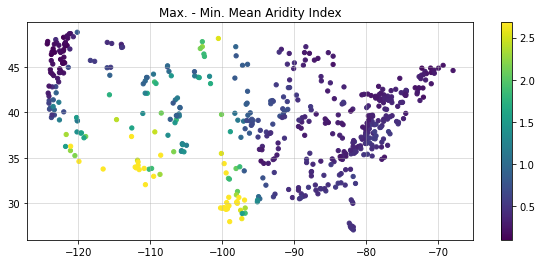

In [30]:
metric = 'delta_aridity'
fig = plt.figure(figsize=([10,4]))

im = plt.scatter(all_df['gauge_lon'], 
          all_df['gauge_lat'],
          c=all_df[metric],
           s=18,
#                 vmin=-0.5,
                    vmax=np.mean(all_df[metric])+np.std(all_df[metric]))#,
#                 cmap='RdBu')

ax = fig.add_subplot(111)

plt.title('Max. - Min. Mean Aridity Index')
# plt.ylabel('Long.')
# plt.xlabel('Lat.')
plt.grid(alpha=0.5)
plt.colorbar(ax = [ax])#,orientation='horizontal')
plt.show()

In [31]:
plt.close('all')

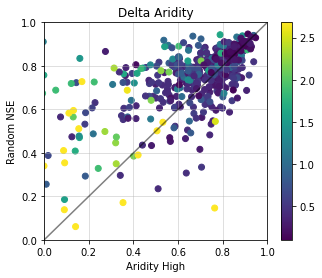

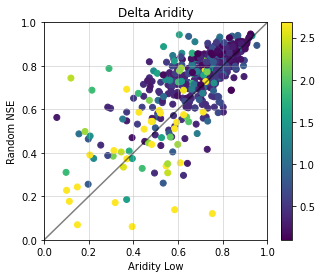

In [32]:
for exp in ext_exps:
    
    plt.figure(figsize=([5,4]))

    title = metric.split('_')
    title = [x.capitalize() for x in title]
    title = ' '.join(title)
    
    ttt = exp.split('_')
    ttt = [x.capitalize() for x in ttt]
    ttt = ' '.join(ttt)

    im = plt.scatter(metrics_dict[ext_model][exp]['nse'],
               mean_rand,
               c=all_df['delta_aridity'],
#                cmap='Blues',
                    vmax=np.mean(all_df[metric])+np.std(all_df[metric]))#,

    plt.ylim([0,1])
    plt.xlim([0,1])
    plt.plot([0,1],'k',alpha=0.5)
    plt.title(f'{title}')
    plt.xlabel(f'{ttt}')
    plt.ylabel(f'Random NSE')
    plt.colorbar(im)
    plt.grid(True,alpha=0.5)

    plt.show()

In [33]:
plt.close('all')

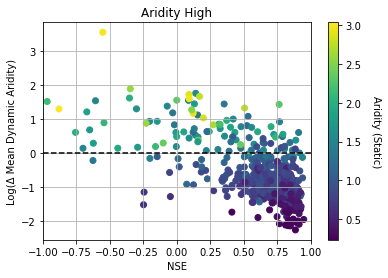

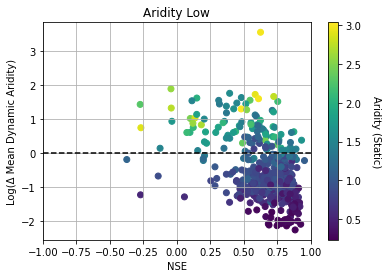

In [47]:
for x in [x for x in all_df.columns if '_nse' in x and not '_deg' in x]:
    
    plt.scatter(all_df[x],np.log(all_df[f'delta_{climate_index}']),c=attributes[climate_index])#,vmax=6)
    
    title = x.split('_')[:-1]
    title = [x.capitalize() for x in title]
    title = ' '.join(title)

    plt.plot([-1,1],[0,0],'k--')
    plt.xlim(-1,1)
    plt.ylabel(f'Log(Δ Mean Dynamic {climate_index.capitalize()})')
    plt.xlabel('NSE')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(f'{climate_index.capitalize()} ({inputs.capitalize()})', rotation=270, labelpad=20)
    plt.grid(True)
    plt.show()

In [ ]:
plt.close('all')

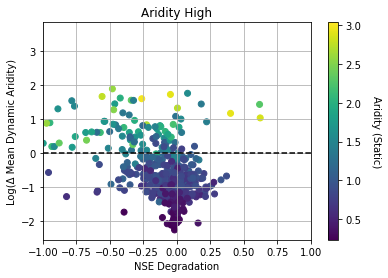

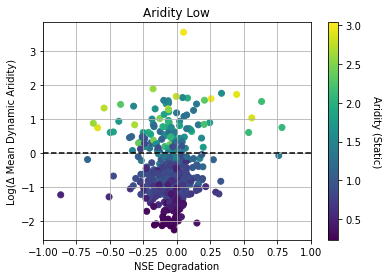

In [52]:
for x in [x for x in all_df.columns if '_deg' in x]:
    
    plt.scatter(all_df[x],np.log(all_df[f'delta_{climate_index}']),c=attributes[climate_index])#,vmax=6)
    
    title = x.split('_')[:-2]
    title = [x.capitalize() for x in title]
    title = ' '.join(title)

    plt.plot([-1,1],[0,0],'k--')
    plt.xlim(-1,1)
    plt.ylabel(f'Log(Δ Mean Dynamic {climate_index.capitalize()})')
    plt.xlabel('NSE Degradation')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(f'{climate_index.capitalize()} ({inputs.capitalize()})', rotation=270, labelpad=20)
    plt.grid(True)
    plt.show()

In [ ]:
plt.close('all')

In [53]:
all_df.iloc[:,:-2].corr()

,delta_aridity,aridity_high_nse,aridity_low_nse,aridity_high_nse_deg,aridity_low_nse_deg
delta_aridity,1.000000,-0.231470,-0.124043,-0.183381,-0.030121
aridity_high_nse,-0.231470,1.000000,0.111592,0.983967,0.018396
aridity_low_nse,-0.124043,0.111592,1.000000,0.034371,0.951616
aridity_high_nse_deg,-0.183381,0.983967,0.034371,1.000000,-0.007034
aridity_low_nse_deg,-0.030121,0.018396,0.951616,-0.007034,1.000000


(-0.5, 0.5)

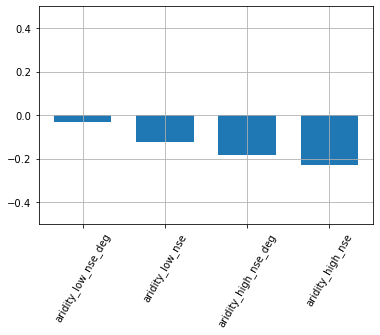

In [54]:
plt.bar(all_df.iloc[:,:-2].corr()[1:].index,
        all_df.iloc[:,:-2].corr()['delta_aridity'][1:].sort_values(ascending=False),width=0.7)

plt.xticks(range(4),labels=all_df.iloc[:,:-2].corr()['delta_aridity'][1:].sort_values(ascending=False).index,
          rotation=60)

plt.grid(True)

plt.ylim(-0.5,0.5)

/home/lmqualls/anaconda3/envs/neuralhydrology/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


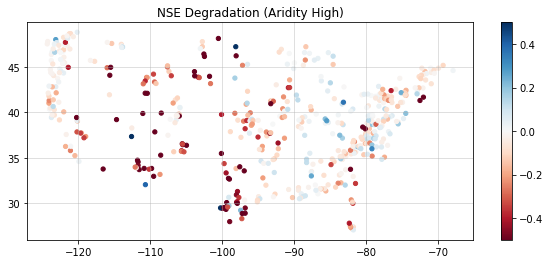

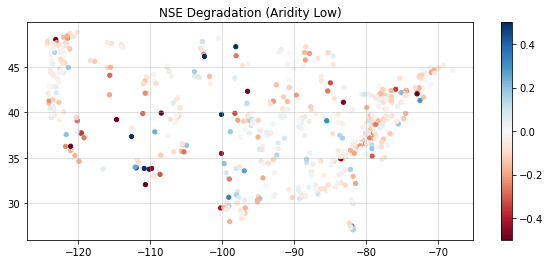

In [64]:
metric = f'delta_{climate_index}'

for exp in ext_exps:
    
    fig = plt.figure(figsize=([10,4]))

    im = plt.scatter(all_df['gauge_lon'], 
              all_df['gauge_lat'],
              c=all_df[f'{exp}_nse_deg'],
               s=18,
                    vmin=-0.5,
                        vmax=0.5,#,
                    cmap='RdBu')
    
    title = exp.split('_')
    title = [x.capitalize() for x in title]
    title = ' '.join(title)

    ax = fig.add_subplot(111)

    plt.title(f'NSE Degradation ({title})')
    plt.grid(alpha=0.5)
    plt.colorbar(ax = [ax])
    plt.show()